In [1]:
#### 

import torch
import sys
sys.path.append("..")
from singleVis.data import NormalDataProvider
REF_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"

CLEAN_PATH = "/home/yifan/dataset/clean_ref/pairflip/cifar10/0"
sys.path.append(REF_PATH)


from config import config

SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
GPU_ID = config["GPU"]
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
PREPROCESS = VISUALIZATION_PARAMETER["PREPROCESS"]
LAMBDA = VISUALIZATION_PARAMETER["LAMBDA"]
B_N_EPOCHS = VISUALIZATION_PARAMETER["BOUNDARY"]["B_N_EPOCHS"]
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
INIT_NUM = VISUALIZATION_PARAMETER["INIT_NUM"]
ALPHA = VISUALIZATION_PARAMETER["ALPHA"]
BETA = VISUALIZATION_PARAMETER["BETA"]
MAX_HAUSDORFF = VISUALIZATION_PARAMETER["MAX_HAUSDORFF"]
# HIDDEN_LAYER = VISUALIZATION_PARAMETER["HIDDEN_LAYER"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
T_N_EPOCHS = VISUALIZATION_PARAMETER["T_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]

VIS_MODEL_NAME = 'vis'
EVALUATION_NAME = VISUALIZATION_PARAMETER["EVALUATION_NAME"]

SEGMENTS = [(EPOCH_START, EPOCH_END)]
# define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))


ref_provider = NormalDataProvider(REF_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)
tar_provider = NormalDataProvider(CLEAN_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)
ref_train_data = ref_provider.train_representation(200).squeeze()
tar_train_data = tar_provider.train_representation(200).squeeze()
ref_prediction = ref_provider.get_pred(200, ref_train_data)
tar_prediction = tar_provider.get_pred(200, tar_train_data)
ref_prediction_res = ref_prediction.argmax(axis=1)
tar_prediction_res = tar_prediction.argmax(axis=1)
### get confidence scores result
from scipy.special import softmax
import numpy as np
def get_conf(pred):
    scores = np.amax(softmax(pred, axis=1), axis=1)
    return scores
ref_scores = get_conf(ref_prediction)
tar_scores =  get_conf(tar_prediction)

import math
distance_high_indicates = []
same_set_indicates = []
def EMAE(Y, y, a=1.5):
    """
    param：
        Y: 原始序列（假定波动较大）
        y: 拟合序列（假定波动较小）
        a: 指数的自变量，≥1，该值越大，则两序列间的残差（特别是残差的离群值）对EMAE返回值影响的强化作用越明显；
        当a=1时，EMAE化简为MAE。
    return：
        指数MAE值，该值的大小与两条序列间平均偏差程度成正比，该值越大，平均偏差程度越大；
        且两序列间的残差（特别是残差的离群值）对EMAE的影响比MAE大。
    """

    Y, y = np.array(Y), np.array(y)
    Y[Y < 0] = 0  # 使指数的底数≥1，则所有指数均为递增函数
    y[y < 0] = 0
    emae = sum(abs((Y+1)**a - (y+1)**a)) / len(Y)

    return emae

for i in range(len(ref_prediction)):
    mes_val = EMAE(ref_prediction[i], tar_prediction[i])
    if mes_val > 30:
        distance_high_indicates.append(i)
    elif mes_val < 0.3:
        same_set_indicates.append(i)
#### 
diff_indicates = []
same_indicates = []
for i in range(len(ref_prediction)):
    # if tar_prediction_res[i] == ref_prediction_res[i] and ref_scores[i] == tar_scores[i] and  (i in same_set_indicates): 
    if tar_prediction_res[i] == ref_prediction_res[i] and math.fabs(ref_scores[i] - tar_scores[i]) < 0.1 and  (i in same_set_indicates):     
        same_indicates.append(i)
    else:
        diff_indicates.append(i)

# need_adjust_indicates = []
# for i in range(len(ref_prediction)):
#     if tar_prediction_res[i] == ref_prediction_res[i] and ref_scores[i] == tar_scores[i] and  (i in same_set_indicates):     
#         same_indicates.append(i)
#     else:
#         diff_indicates.append(i)
pred_diff_list = []
for i in range(len(ref_prediction)):
    # if tar_prediction_res[i] == ref_prediction_res[i] and ref_scores[i] == tar_scores[i] and  (i in same_set_indicates): 
    if tar_prediction_res[i] != ref_prediction_res[i] or math.fabs(ref_scores[i] - tar_scores[i]) > 0.3:     
        pred_diff_list.append(i)
pred_diff_class = []
for i in range(len(ref_prediction)):
    # if tar_prediction_res[i] == ref_prediction_res[i] and ref_scores[i] == tar_scores[i] and  (i in same_set_indicates): 
    if tar_prediction_res[i] != ref_prediction_res[i]:     
        pred_diff_class.append(i)

print('predict diff sample number:',len(pred_diff_list),'absolute align sample number:',len(same_indicates))

diff_combine_same = np.concatenate((same_indicates, pred_diff_list), axis=0)
# diff_combine_same.sort()
import os
import sys
sys.path.append("..")
from CKA_utils.CKA import CKA, CudaCKA
np_cka = CKA()
print('RBF Kernel CKA, between same subset: {}'.format(np_cka.kernel_CKA(ref_train_data[same_indicates], tar_train_data[same_indicates])))
print('RBF Kernel CKA, between diff subset: {}'.format(np_cka.kernel_CKA(ref_train_data[pred_diff_list], tar_train_data[pred_diff_list])))
print('RBF Kernel CKA, between diff subset: {}'.format(np_cka.kernel_CKA(ref_train_data[pred_diff_class], tar_train_data[pred_diff_class])))
print('RBF Kernel CKA, between same+diff subset: {}'.format(np_cka.kernel_CKA(ref_train_data[diff_combine_same], tar_train_data[diff_combine_same])))

/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Finish initialization...
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 4824.37it/s]


predict diff sample number: 29 absolute align sample number: 17
RBF Kernel CKA, between same subset: 0.9839789807640137
RBF Kernel CKA, between diff subset: 0.864965738707776
RBF Kernel CKA, between diff subset: 0.8951524855774078
RBF Kernel CKA, between same+diff subset: 0.9252515020545594


In [2]:
import torch
import numpy as np
from scipy.spatial.distance import pdist


def rbf(X, sigma=None):
    # X = torch.tensor(X)
    GX = torch.matmul(X, X.T)
    KX = torch.diag(GX) - GX + (torch.diag(GX) - GX).T
    if sigma is None:
        mdist = torch.median(KX[KX != 0])
        sigma = torch.sqrt(mdist)
    KX *= - 0.5 / (sigma * sigma)
    KX = torch.exp(KX)
    return KX

def kernel_HSIC(X, Y, gamma):
    n1 = X.shape[0]
    n2 = Y.shape[0]
    H1 = torch.eye(n1) - torch.ones(n1, n1) / n1
    H2 = torch.eye(n2) - torch.ones(n2, n2) / n2
    K1 = torch.matmul(torch.matmul(H1, rbf(X, gamma)), H1)
    K2 = torch.matmul(torch.matmul(H2, rbf(Y, gamma)), H2)
    hsic = torch.trace(torch.matmul(K1, K2))
    return hsic

def cka(X, Y, sigma=None):
    hsic = kernel_HSIC(X, Y, sigma)
    var1 = torch.tensor(kernel_HSIC(X, X, sigma))
    var2 = torch.tensor(kernel_HSIC(Y, Y, sigma))
    cka = hsic / torch.sqrt(var1 * var2)
    return cka.item()


    
X = torch.randn(100, 10)
Y = torch.randn(100, 10)

cka_value = cka(X, Y)
print(cka_value)


from torch.optim import Adam


def objective_value(Y, X, gamma=None):
 
    K_xx = kernel_HSIC(X, X, gamma)
    K_yy = kernel_HSIC(Y, Y, gamma)
    # K_xy = rbf_kernel(X, Y, 1e-2) 
    K_xy = kernel_HSIC(X, Y, gamma)   
    cka = torch.mean(K_xy) / torch.sqrt(K_xx * K_yy)
    return cka

def objective(Y, X, gamma=None):
 
    K_xx = kernel_HSIC(X, X, gamma)
    K_yy = kernel_HSIC(Y, Y, gamma)
    # K_xy = rbf_kernel(X, Y, 1e-2) 
    K_xy = kernel_HSIC(X, Y, gamma)   
    cka_loss = 1 - torch.mean(K_xy) / torch.sqrt(K_xx * K_yy)
    return cka_loss

Y = torch.randn(100, 10, requires_grad=True)
optimizer = Adam([Y], lr=1e-2)



for i in range(10):
    loss = objective(X,Y)
    optimizer.zero_grad()
    loss.backward()
    print('loss',loss)
    optimizer.step()
    
print('RBF Kernel CKA, between same subset: {}'.format(objective_value(torch.Tensor(ref_train_data[same_indicates]), torch.Tensor(tar_train_data[same_indicates]))))
print('RBF Kernel CKA, between diff subset: {}'.format(objective_value(torch.Tensor(ref_train_data[pred_diff_list]), torch.Tensor(tar_train_data[pred_diff_list]))))
print('RBF Kernel CKA, between diff subset: {}'.format(objective_value(torch.Tensor(ref_train_data[pred_diff_class]), torch.Tensor(tar_train_data[pred_diff_class]))))
print('RBF Kernel CKA, between same+diff subset: {}'.format(objective_value(torch.Tensor(ref_train_data[diff_combine_same]), torch.Tensor(tar_train_data[diff_combine_same]))))

print('RBF Kernel CKA, between same subset: {}'.format(cka(torch.Tensor(ref_train_data[same_indicates]), torch.Tensor(tar_train_data[same_indicates]))))
print('RBF Kernel CKA, between diff subset: {}'.format(cka(torch.Tensor(ref_train_data[pred_diff_list]), torch.Tensor(tar_train_data[pred_diff_list]))))
print('RBF Kernel CKA, between diff subset: {}'.format(cka(torch.Tensor(ref_train_data[pred_diff_class]), torch.Tensor(tar_train_data[pred_diff_class]))))
print('RBF Kernel CKA, between same+diff subset: {}'.format(cka(torch.Tensor(ref_train_data[diff_combine_same]), torch.Tensor(tar_train_data[diff_combine_same]))))

/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0.16099871695041656
loss tensor(0.8461, grad_fn=<RsubBackward1>)
loss tensor(0.8418, grad_fn=<RsubBackward1>)
loss tensor(0.8375, grad_fn=<RsubBackward1>)
loss tensor(0.8331, grad_fn=<RsubBackward1>)
loss tensor(0.8288, grad_fn=<RsubBackward1>)
loss tensor(0.8244, grad_fn=<RsubBackward1>)
loss tensor(0.8199, grad_fn=<RsubBackward1>)
loss tensor(0.8154, grad_fn=<RsubBackward1>)
loss tensor(0.8109, grad_fn=<RsubBackward1>)
loss tensor(0.8064, grad_fn=<RsubBackward1>)
RBF Kernel CKA, between same subset: 0.9840232729911804
RBF Kernel CKA, between diff subset: 0.8649914264678955
RBF Kernel CKA, between diff subset: 0.8951765894889832
RBF Kernel CKA, between same+diff subset: 0.9252514839172363
RBF Kernel CKA, between same subset: 0.9840231537818909
RBF Kernel CKA, between diff subset: 0.8649914264678955
RBF Kernel CKA, between diff subset: 0.8951765894889832
RBF Kernel CKA, between same+diff subset: 0.9252516031265259


In [3]:
from alignment.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=200,TAR_EPOCH=200)

100%|██████████| 250/250 [00:00<00:00, 4521.40it/s]


In [4]:
aaa = gen.generate_representation_by_cka(35, 0.5,200)

absolute alignment indicates number: 51 label diff indicates number: 17 confidence diff indicates number: 12
Iteration 0: CKA loss = 0.0005420947
Iteration 9: CKA loss = 0.0004764670
Iteration 18: CKA loss = 0.0004132652
Iteration 27: CKA loss = 0.0003642154
Iteration 36: CKA loss = 0.0003271782
Iteration 45: CKA loss = 0.0003002518
Iteration 54: CKA loss = 0.0002774191
Iteration 63: CKA loss = 0.0002604544
Iteration 72: CKA loss = 0.0002466196
Iteration 81: CKA loss = 0.0002354908
Iteration 90: CKA loss = 0.0002295828
Iteration 99: CKA loss = 0.0002232629
Iteration 108: CKA loss = 0.0002148938
Iteration 117: CKA loss = 0.0002059084
Iteration 126: CKA loss = 0.0002016270
Iteration 135: CKA loss = 0.0001998734
Iteration 144: CKA loss = 0.0001977450
Iteration 153: CKA loss = 0.0001971447
Iteration 162: CKA loss = 0.0001952636
Iteration 171: CKA loss = 0.0001919562
Iteration 180: CKA loss = 0.0001888853
Iteration 189: CKA loss = 0.0001870519
Iteration 198: CKA loss = 0.0001856148


In [6]:
absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates = gen.subsetClassify(35, 0.5)
diff_combine_same = np.concatenate((absolute_alignment_indicates, predict_label_diff_indicates), axis=0)
print('adjusted vs target CKA, between diff subset: {}'.format(np_cka.kernel_CKA(aaa, tar_train_data[diff_combine_same])))
print('adjusted vs reference CKA, between diff subset: {}'.format(np_cka.kernel_CKA(aaa, ref_train_data[diff_combine_same])))
print('RBF Kernel CKA, between diff subset: {}'.format(np_cka.kernel_CKA(ref_train_data[diff_combine_same], tar_train_data[diff_combine_same])))
print('RBF Kernel CKA, between diff subset: {}'.format(np_cka.kernel_CKA(ref_train_data[predict_label_diff_indicates], tar_train_data[predict_label_diff_indicates])))
print('RBF Kernel CKA, between diff subset: {}'.format(np_cka.kernel_CKA(aaa, tar_train_data[diff_combine_same])))


absolute alignment indicates number: 51 label diff indicates number: 17 confidence diff indicates number: 12
adjusted vs target CKA, between diff subset: 0.9815140519601658
adjusted vs reference CKA, between diff subset: 0.9684788175397692
RBF Kernel CKA, between diff subset: 0.9457883366104397
RBF Kernel CKA, between diff subset: 0.8951524855774078
RBF Kernel CKA, between diff subset: 0.9815140519601658


In [7]:
representation = ref_provider.train_representation(200)
k = 0
for i in range(len(diff_combine_same)):
    index = diff_combine_same[i]
    representation[index] = aaa[k]
    k = k + 1


In [8]:
representation.shape

(50000, 512)

Computing decision regions ...


100%|██████████| 1/1 [00:00<00:00, 1179.17it/s]


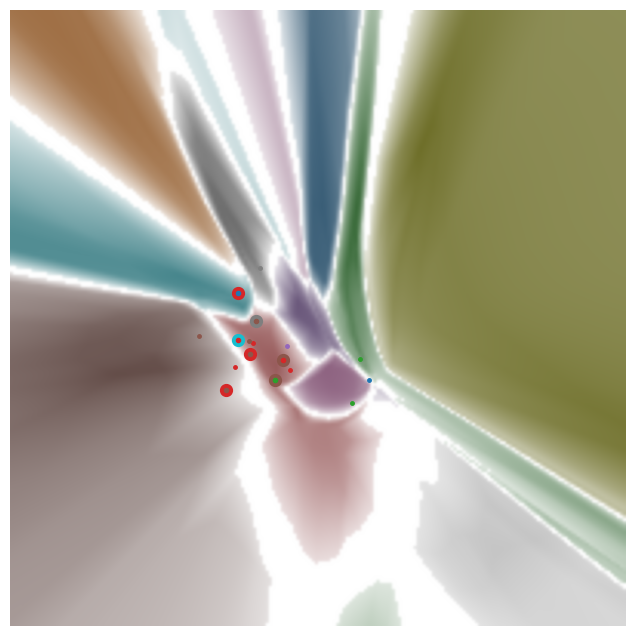

In [12]:
import json
import os
from singleVis.SingleVisualizationModel import SingleVisualizationModel
from singleVis.projector import TimeVisProjector
# model = VisModel(ENCODER_DIMS, DECODER_DIMS)
model = SingleVisualizationModel(input_dims=512, output_dims=2, units=256, hidden_layer=4)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(200),I), projector, 200,[predict_label_diff_indicates],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 5492.95it/s]
../representationTrans/trans_visualizer_border.py:186: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_data = self.data_provider.train_representation(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:187: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_labels = self.data_provider.train_labels(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us

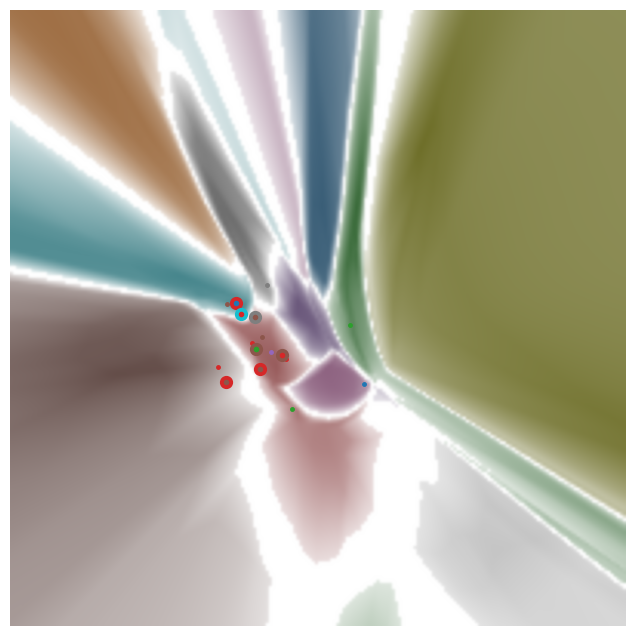

In [9]:
import json
import os
from singleVis.SingleVisualizationModel import SingleVisualizationModel
from singleVis.projector import TimeVisProjector
# model = VisModel(ENCODER_DIMS, DECODER_DIMS)
model = SingleVisualizationModel(input_dims=512, output_dims=2, units=256, hidden_layer=4)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(representation,I), projector, 200,[predict_label_diff_indicates],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 1/1 [00:00<00:00, 3218.96it/s]


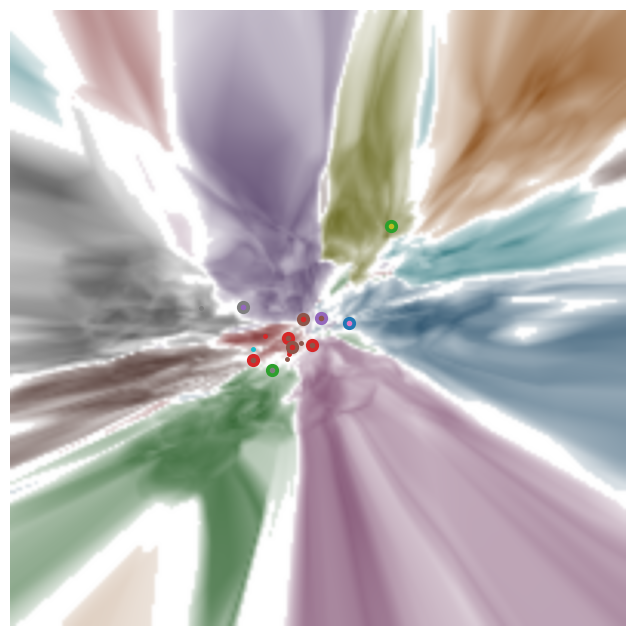

In [14]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
# model = SingleVisualizationModel(input_dims=512, output_dims=2, units=256, hidden_layer=4)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, I,I, np.dot(tar_provider.train_representation(200),I), projector, 200,[predict_label_diff_indicates],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [6]:
absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates = gen.subsetClassify(35, 0.5)
diff_combine_same = np.concatenate((absolute_alignment_indicates, predict_label_diff_indicates), axis=0)
print('RBF Kernel CKA, between diff subset: {}'.format(np_cka.kernel_CKA(aaa, tar_train_data[diff_combine_same])))
print('RBF Kernel CKA, between diff subset: {}'.format(np_cka.kernel_CKA(aaa, ref_train_data[diff_combine_same])))
print('RBF Kernel CKA, between diff subset: {}'.format(np_cka.kernel_CKA(ref_train_data[diff_combine_same], tar_train_data[diff_combine_same])))
print('RBF Kernel CKA, between diff subset: {}'.format(np_cka.kernel_CKA(ref_train_data[predict_label_diff_indicates], tar_train_data[predict_label_diff_indicates])))
print('RBF Kernel CKA, between diff subset: {}'.format(np_cka.kernel_CKA(aaa, tar_train_data[diff_combine_same])))


absolute alignment indicates number: 51 label diff indicates number: 17 confidence diff indicates number: 12
RBF Kernel CKA, between diff subset: 0.9999986883213225
RBF Kernel CKA, between diff subset: 0.945861601405903
RBF Kernel CKA, between diff subset: 0.9457883366104397
RBF Kernel CKA, between diff subset: 0.8951524855774078
RBF Kernel CKA, between diff subset: 0.9999986883213225


In [23]:
len(diff_combine_same)

68

In [24]:
len(predict_label_diff_indicates)

17

In [20]:
need_update_arr = np.arange(51,len(diff_combine_same))

In [21]:
need_update_arr

array([51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67])

range(1, 101, 2)

In [12]:
# len(absolute_alignment_indicates)
aaa[:51]

array([[ 0.4438144 ,  0.25794092,  0.88561094, ..., -0.30997425,
         0.04925713,  0.7036765 ],
       [ 1.6506764 ,  0.62257606,  0.77443874, ...,  0.6457486 ,
         0.78697693,  1.9612937 ],
       [ 1.9230452 ,  1.8043541 ,  1.0690829 , ...,  1.2825058 ,
         2.058473  ,  2.411501  ],
       ...,
       [ 3.0967503 ,  0.83601546,  0.6276946 , ...,  0.3334073 ,
         0.04557479,  0.7800593 ],
       [ 0.29652357,  2.2157164 ,  1.0826873 , ...,  2.091645  ,
         1.8267734 ,  1.8171103 ],
       [ 2.123877  ,  1.9573641 ,  1.6897701 , ...,  1.3778095 ,
         2.8267016 ,  3.128074  ]], dtype=float32)

In [9]:
ref_train_data[absolute_alignment_indicates]

array([[0.35264334, 0.25828406, 0.83623934, ..., 0.        , 0.20785208,
        0.60769653],
       [1.7937965 , 0.5171929 , 0.2944022 , ..., 0.88652   , 1.0262028 ,
        1.7159932 ],
       [1.2522422 , 1.998488  , 1.3770924 , ..., 0.93216276, 1.8701797 ,
        2.7967405 ],
       ...,
       [2.7049246 , 0.6912097 , 0.3405223 , ..., 0.5076878 , 0.05851028,
        0.56205   ],
       [0.        , 1.9117651 , 1.4406421 , ..., 1.7921157 , 1.6261466 ,
        1.8802838 ],
       [1.8142302 , 1.6700609 , 1.9396539 , ..., 1.6751497 , 2.6756046 ,
        2.865216  ]], dtype=float32)

In [8]:
aaa

array([[ 0.4438144 ,  0.25794092,  0.88561094, ..., -0.30997425,
         0.04925713,  0.7036765 ],
       [ 1.6506764 ,  0.62257606,  0.77443874, ...,  0.6457486 ,
         0.78697693,  1.9612937 ],
       [ 1.9230452 ,  1.8043541 ,  1.0690829 , ...,  1.2825058 ,
         2.058473  ,  2.411501  ],
       ...,
       [ 1.2586628 , -0.02370401,  0.35129252, ...,  0.12940982,
         0.5937384 ,  0.4538625 ],
       [ 0.12163609,  1.2681662 ,  0.43215007, ...,  0.61959136,
        -0.26734826,  0.27205062],
       [-0.2988844 ,  1.0104567 ,  0.21589582, ...,  0.538526  ,
        -0.14185655, -0.20807993]], dtype=float32)

In [14]:
absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates = gen.subsetClassify(35, 1)

absolute alignment indicates number: 405 label diff indicates number: 17 confidence diff indicates number: 12


In [4]:
aaa

tensor([[ 3.0787e-01,  4.5586e-01,  1.2183e+00,  ...,  9.7048e-03,
          3.6762e-01,  9.9860e-02],
        [ 6.7021e-01,  2.3573e-02,  9.6027e-03,  ...,  9.2427e-05,
          8.9656e-01,  8.8440e-04],
        [ 0.0000e+00,  1.0089e-02,  1.1115e-02,  ...,  1.4065e+00,
          4.0381e-01,  0.0000e+00],
        ...,
        [-2.8396e-01,  2.0677e+00,  6.0495e-01,  ...,  4.7041e-01,
          1.5229e+00, -1.9884e-01],
        [ 1.5869e+00,  5.3166e-01,  1.1167e+00,  ...,  5.5588e-01,
          1.4619e+00, -1.5788e+00],
        [-3.7586e-01,  9.3878e-02, -2.0133e+00,  ...,  5.2337e-01,
          1.6253e+00,  1.2470e+00]], grad_fn=<CatBackward0>)

In [5]:
aaa

tensor([[ 3.0787e-01,  4.5586e-01,  1.2183e+00,  ...,  9.7048e-03,
          3.6762e-01,  9.9860e-02],
        [ 6.7021e-01,  2.3573e-02,  9.6027e-03,  ...,  9.2427e-05,
          8.9656e-01,  8.8440e-04],
        [ 0.0000e+00,  1.0089e-02,  1.1115e-02,  ...,  1.4065e+00,
          4.0381e-01,  0.0000e+00],
        ...,
        [-4.6379e-01, -3.9944e-01,  3.2981e-01,  ...,  4.5481e-01,
         -1.9631e+00,  1.5185e+00],
        [-1.1161e+00, -1.7232e+00, -9.9265e-01,  ..., -4.2883e-02,
         -1.0176e+00,  1.1383e+00],
        [-2.5949e-01, -8.4106e-02,  4.6334e-01,  ..., -4.1069e-01,
          2.6556e-01, -9.1836e-01]], grad_fn=<CatBackward0>)

In [60]:
import torch
import numpy as np
from scipy.spatial.distance import pdist

# def rbf_kernel(X, Y, gamma):
#     X_norms = (X ** 2).sum(dim=1, keepdim=True)
#     Y_norms = (Y ** 2).sum(dim=1, keepdim=True)
#     K = torch.exp(-gamma * (X_norms + Y_norms.T - 2 * torch.mm(X, Y.T)))
#     return K

def centering(K):
    n = K.shape[0]
    unit = torch.ones([n, n])
    I = torch.eye(n)
    H = I - unit / n
    K = torch.tensor(K)
    return torch.matmul(torch.matmul(H, K), H)

# def rbf(X, sigma=None):
#         GX = np.dot(X, X.T)
#         KX = np.diag(GX) - GX + (np.diag(GX) - GX).T
#         if sigma is None:
#             mdist = np.median(KX[KX != 0])
#             sigma = math.sqrt(mdist)
#         KX *= - 0.5 / (sigma * sigma)
#         KX = np.exp(KX)
#         return KX

def rbf(X, sigma=None):
    # X = torch.tensor(X)
    GX = torch.matmul(X, X.T)
    KX = torch.diag(GX) - GX + (torch.diag(GX) - GX).T
    if sigma is None:
        mdist = torch.median(KX[KX != 0])
        sigma = torch.sqrt(mdist)
    KX *= - 0.5 / (sigma * sigma)
    KX = torch.exp(KX)
    return KX


def kernel_HSIC(X, Y, sigma):
    K_X = centering(rbf(X, sigma))
    K_Y = centering(rbf(Y, sigma))
    hsic = torch.sum(K_X * K_Y)
    return hsic.item()

def rbf_kernel(X, sigma=None):
    # X = torch.tensor(X)
    GX = torch.matmul(X, X.T)
    KX = torch.diag(GX) - GX + (torch.diag(GX) - GX).T
    if sigma is None:
        mdist = torch.median(KX[KX != 0])
        sigma = torch.sqrt(mdist)
    KX *= - 0.5 / (sigma * sigma)
    KX = torch.exp(KX)
    return KX


def cka(X, Y, sigma=None):
    K_X = centering(rbf(X, sigma))
    K_Y = centering(rbf(Y, sigma))
    hsic = torch.sum(K_X * K_Y)
    return hsic.item()
    
X = torch.randn(100, 10)
Y = torch.randn(100, 10)

cka_value = cka(X, Y)

def objective(Y, X=X, gamma=None):
    K_xx = rbf_kernel(X, gamma)
    K_yy = rbf_kernel(Y, gamma)
    K_xy = kernel_HSIC(X, Y, gamma)
    cka = torch.mean(K_xy) / torch.sqrt(torch.mean(K_xx) * torch.mean(K_yy))
    return -cka

from torch.optim import Adam

Y = torch.randn(100, 10, requires_grad=True)
optimizer = Adam([Y], lr=1e-2)

for i in range(10):
    loss = objective(Y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(loss)

Y = Y.detach().numpy()

print('RBF Kernel CKA, between same subset: {}'.format(cka(torch.Tensor(ref_train_data[same_indicates]), torch.Tensor(tar_train_data[same_indicates]))))
print('RBF Kernel CKA, between diff subset: {}'.format(cka(torch.Tensor(ref_train_data[pred_diff_list]), torch.Tensor(tar_train_data[pred_diff_list]))))
print('RBF Kernel CKA, between diff subset: {}'.format(cka(torch.Tensor(ref_train_data[pred_diff_class]), torch.Tensor(tar_train_data[pred_diff_class]))))
print('RBF Kernel CKA, between same+diff subset: {}'.format(cka(torch.Tensor(ref_train_data[diff_combine_same]), torch.Tensor(tar_train_data[diff_combine_same]))))


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


TypeError: new(): data must be a sequence (got float)

In [53]:
import torch
import numpy as np
from scipy.spatial.distance import pdist

def rbf_kernel(X, Y, gamma):
    X_norms = (X ** 2).sum(dim=1, keepdim=True)
    Y_norms = (Y ** 2).sum(dim=1, keepdim=True)
    K = torch.exp(-gamma * (X_norms + Y_norms.T - 2 * torch.mm(X, Y.T)))
    return K


def cka(X, Y, gamma=1e-2):
    K_xx = rbf_kernel(X, X, gamma)
    K_yy = rbf_kernel(Y, Y, gamma)
    K_xy = rbf_kernel(X, Y, gamma)
    cka = torch.mean(K_xy) / torch.sqrt(torch.mean(K_xx) * torch.mean(K_yy))
    return cka.item()
    
X = torch.randn(100, 10)
Y = torch.randn(100, 10)

cka_value = cka(X, Y)

def objective(Y, X=X, gamma=1e-2):
    K_xx = rbf_kernel(X, X, gamma)
    K_yy = rbf_kernel(Y, Y, gamma)
    K_xy = rbf_kernel(X, Y, gamma)
    cka = torch.mean(K_xy) / torch.sqrt(torch.mean(K_xx) * torch.mean(K_yy))
    return -cka

from torch.optim import Adam

Y = torch.randn(100, 10, requires_grad=True)
optimizer = Adam([Y], lr=1e-2)

for i in range(10):
    loss = objective(Y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(loss)

Y = Y.detach().numpy()

print('RBF Kernel CKA, between same subset: {}'.format(cka(torch.Tensor(ref_train_data[same_indicates]), torch.Tensor(tar_train_data[same_indicates]))))
print('RBF Kernel CKA, between diff subset: {}'.format(cka(torch.Tensor(ref_train_data[pred_diff_list]), torch.Tensor(tar_train_data[pred_diff_list]))))
print('RBF Kernel CKA, between diff subset: {}'.format(cka(torch.Tensor(ref_train_data[pred_diff_class]), torch.Tensor(tar_train_data[pred_diff_class]))))
print('RBF Kernel CKA, between same+diff subset: {}'.format(cka(torch.Tensor(ref_train_data[diff_combine_same]), torch.Tensor(tar_train_data[diff_combine_same]))))


tensor(-0.9984, grad_fn=<NegBackward0>)
tensor(-0.9985, grad_fn=<NegBackward0>)
tensor(-0.9987, grad_fn=<NegBackward0>)
tensor(-0.9988, grad_fn=<NegBackward0>)
tensor(-0.9989, grad_fn=<NegBackward0>)
tensor(-0.9990, grad_fn=<NegBackward0>)
tensor(-0.9991, grad_fn=<NegBackward0>)
tensor(-0.9992, grad_fn=<NegBackward0>)
tensor(-0.9993, grad_fn=<NegBackward0>)
tensor(-0.9994, grad_fn=<NegBackward0>)
RBF Kernel CKA, between same subset: 0.7649381160736084
RBF Kernel CKA, between diff subset: 0.882797122001648
RBF Kernel CKA, between diff subset: 0.8677344918251038
RBF Kernel CKA, between same+diff subset: 0.8875225782394409


In [ ]:
sss = cka(ref_train_data[diff_combine_same], tar_train_data[diff_combine_same],)

In [ ]:

# Step2: Computing the loss 
def compute_loss(X, Y, R):
    '''
    Inputs: 
       X: a matrix of dimension (m,n) where the columns are the English embeddings.
       Y: a matrix of dimension (m,n) where the columns correspong to the French embeddings.
       R: a matrix of dimension (n,n) - transformation matrix from English to French vector space embeddings.
    Outputs:
       L: a matrix of dimension (m,n) - the value of the loss function for given X, Y and R.
    '''
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    # m is the number of rows in X
    m = len(X)

    # diff is XR - Y
    diff = np.dot(X, R) - Y

    # diff_squared is the element-wise square of the difference
    diff_squared = diff**2

    # sum_diff_squared is the sum of the squared elements
    sum_diff_squared = diff_squared.sum()

    # loss is the sum_diff_squared divided by the number of examples (m)
    loss = sum_diff_squared/m
    ### END CODE HERE ###
    return loss
def compute_gradient(X, Y, R):
    '''
        the gradient of the loss with respect to the matrix encodes how much a tiny change 
    in some coordinate of that matrix affect the change of loss function.
        Gradient descent uses that information to iteratively change matrix R until we reach 
    a point where the loss is minimized.
    Inputs: 
        X: a matrix of dimension (m,n) where the colums are the contrast representation 
        Y: a matrix of dimension (m,n) where the colums are the reference representation
        R: a matrix of dimension (n,n) - transformation matrix from Y2d to X2d
    Outputs:
       g: a matrix of dimension (n,n) - gradient of the loss function L for given X, Y and R.
    '''
    # m is the number of rows in X
    m = len(X)

    rows, columns = X.shape

    gradient = (np.dot(X.T, np.dot(X, R) - Y) * 2)/rows
    assert gradient.shape == (columns, columns)
    ### END CODE HERE ###
    return gradient


# Most of the time we iterate for a fixed number of training steps rather than iterating until the loss falls below a threshold.

# 1.Calculate gradient g of the loss with respect to the matrix R. 
# 2. Update R (Rnew = Rold - αg) . α is the learning rate which is a scalar.

# alignment_embeddings
def align_embeddings(X: np.ndarray, Y: np.ndarray,
                      train_steps:int,
                      learning_rate: float=0.0003,
                      seed: int=129) -> np.ndarray:
    '''
    Finding the optimal R with gradient descent algorithm
    Inputs:
        X: a matrix of dimension (m,n) where the colums are the contrast representation 
        Y: a matrix of dimension (m,n) where the colums are the reference representation
        learning_rate: positive float - describes how big steps will  gradient descent algorithm do.
    Outputs:
        R: a matrix of dimension (n,n) - the projection matrix that minimizes the F norm ||projector(X R) - projector ( Y )||^2
    '''
    # the number of columns in X is the number of dimensions for a word vector (e.g. 300)
    # R is a square matrix with length equal to the number of dimensions in th  word embedding
    R = np.random.rand(X.shape[1], X.shape[1])
    # R = Variable(torch.ones(X.shape[1],X.shape[1]),requires_grad=True)

   

        
    # train_steps = 100000
    for i in range(train_steps):
        if i%1000 == 0:
            loss = compute_loss(X,Y,R)
            print(f"iteration {i}, loss {loss}") 



        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
        # use the function that you defined to compute the gradient
        gradient = compute_gradient(X, Y, R)
       
        
         # update R by subtracting the learning rate times gradient
        R -= learning_rate * gradient
        ### END CODE HERE ###
    
    return R


In [ ]:
len(pred_diff_class)
ref_train_data = ref_provider.train_representation(200).squeeze()
ref_res_idx = list(zip(range(len(ref_prediction_res)),ref_prediction_res))
ref_scores_idx = list(zip(range(len(ref_scores)),ref_scores))

for i in range(len(pred_diff_class)):
    index = pred_diff_class[i]
    ###### find same prediction result in reference
    pred_res_in_target = tar_prediction_res[index]
    score = tar_scores[index]
    res_idx = list(filter(lambda x:x[1]==pred_res_in_target,ref_res_idx))

    res_idx = list(zip(*res_idx))[0]
    if len(res_idx):
        score_idx = list(filter(lambda x:np.logical_and(x[0] in res_idx,math.fabs(x[1] - score) < 0.1),ref_scores_idx))
        
        if len(score_idx):
            score_idx = list(zip(*score_idx))[0]
            if i%10 == 0:
                print('111',index, score_idx[0])
            ref_train_data[index] = ref_train_data[score_idx[0]]


    # print('res',pred_res_in_target, 'res',len(score_idx))

In [ ]:
X = ref_train_data[same_indicates]
Y = tar_train_data[same_indicates]
S_for_same = align_embeddings(X, Y, 35000)

In [ ]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

show_list = [pred_diff_class[0],pred_diff_class[1],pred_diff_class[7],pred_diff_class[8],pred_diff_class[14],pred_diff_class[16],
             pred_diff_class[18],
             pred_diff_class[20],pred_diff_class[25],pred_diff_class[29],pred_diff_class[30],pred_diff_class[32],pred_diff_class[33],
             pred_diff_class[42],pred_diff_class[43],pred_diff_class[44],pred_diff_class[45],
             ]
I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider , S_for_same,I, ref_train_data, projector, 200,[show_list],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
show_list = [pred_diff_class[0],pred_diff_class[1],pred_diff_class[7],pred_diff_class[8],pred_diff_class[14],pred_diff_class[16],
             pred_diff_class[18],
             pred_diff_class[20],pred_diff_class[25],pred_diff_class[29],pred_diff_class[30],pred_diff_class[32],pred_diff_class[33],
             pred_diff_class[42],pred_diff_class[43],pred_diff_class[44],pred_diff_class[45],
             ]
I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(200),I), projector, 200,[show_list],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
# use prediction differenct subset train S_for_diff, use S_for_diff generate diff predict samples
X = ref_train_data[same_indicates]
Y = tar_train_data[same_indicates]
R_for_same = align_embeddings(Y, X, 35000)

In [ ]:
# X = ref_train_data[diff_combine_same]
# Y = tar_train_data[diff_combine_same]
# S = align_embeddings(X, Y, 25000)
# X = ref_train_data[diff_combine_same]
# Y = tar_train_data[diff_combine_same]
# R = align_embeddings(Y, X, 25000)
# adjusted

In [ ]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, S_for_same,I, np.dot(tar_provider.train_representation(200),R_for_same), projector, 200,[pred_diff_list],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
diff_combine_same = np.concatenate((pred_diff_list, same_indicates), axis=0)

In [ ]:
# np.concatenate(ref_train_data[same_indicates], np.array([ref_train_data[index]])).shape


# samelist.append(ref_train_data[0])
# la = np.append(samelist, ref_train_data[0], axis=None) 
# la.shape   
# print(index,'RBF Kernel CKA, between diff subset: {}'.format(np_cka.kernel_CKA(ref_train_data[diff_combine_same], tar_train_data[diff_combine_same]))) 
stand = np_cka.kernel_CKA(ref_train_data[diff_combine_same], tar_train_data[diff_combine_same])                
for i in range(len(res_idx)):
    index = res_idx[i]
    samelist1 = ref_train_data[diff_combine_same]
    samelist1[0] = ref_train_data[index]

    if(stand - np_cka.kernel_CKA(samelist1, tar_train_data[diff_combine_same]) < 0.001):
        print(index,'RBF Kernel CKA, between diff subset: {}'.format(np_cka.kernel_CKA(samelist1, tar_train_data[diff_combine_same])))

    

    

In [ ]:
def find_sta_CKA(res_idx, need_adjust_index,ref_representations, tar_representations, threthold):
    """
        res_idx: search subset
        need_adjust_index: index of the need adjusted sample
        ref_representations: reference representation sub set
        tar_representations: target representation sub set
        threthold: current CKA
    """
    stand_val = np_cka.kernel_CKA(ref_representations, tar_representations)           
    idx = []
    for i in range(len(res_idx)):
        index = res_idx[i]
        ref_representations[need_adjust_index] = ref_train_data[index]

        if (stand_val - np_cka.kernel_CKA(ref_representations, tar_representations) < threthold):
            idx.append(index)
    return idx

In [ ]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, S_for_same,I, np.dot(tar_provider.train_representation(200),R_for_same), projector, 200,[pred_diff_list],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, S_for_same,I, np.dot(tar_provider.train_representation(200),R_for_same), projector, 200,[pred_diff_list],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, I,I, np.dot(tar_provider.train_representation(200),I), projector, 200,[pred_diff_list],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(200),I), projector, 200,[pred_diff_list],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(200),I), projector, 200,[pred_diff_class],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
X = np.dot(ref_train_data[pred_diff_list],S_for_diff)
Y = tar_train_data[pred_diff_list]
print('RBF Kernel CKA, between np.dot(ref_train_data[pred_diff_list],S_for_diff) and tar_train_data[pred_diff_list]: {}'.format(np_cka.kernel_CKA(X, Y)))